In [1]:
%matplotlib notebook

import matplotlib.pyplot as plt
import pvlib

import cpvlib
from insolight_parameters import mod_params_cpv, mod_params_diffuse

In [2]:
lat, lon = 40.4, -3.7

data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

data = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data.set_index(
    data.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=695, tz='utc')

solar_zenith = location.get_solarposition(data.index).zenith
solar_azimuth = location.get_solarposition(data.index).azimuth

StaticHybridSystem

In [3]:
static_hybrid_sys = cpvlib.StaticHybridSystem(
    surface_tilt=30,
    surface_azimuth=180,
    module_cpv=None,
    module_diffuse=None,
    module_parameters_cpv=mod_params_cpv,
    module_parameters_diffuse=mod_params_diffuse,
    modules_per_string=1,
    strings_per_inverter=1,
    inverter=None,
    inverter_parameters=None,
    racking_model="insulated",
    losses_parameters=None,
    name=None,
)

get_effective_irradiance

In [4]:
data['dii_effective'], data['poa_diffuse_static_effective'] = static_hybrid_sys.get_effective_irradiance(
    solar_zenith,
    solar_azimuth,
    iam_param=0.7,
    aoi_limit=55,
    dii=None,
    ghi=data['ghi'],
    dhi=data['dhi'],
    dni=data['dni']
)

pvsyst_celltemp

In [5]:
data['temp_cell_35'], data['temp_cell_diffuse'] = static_hybrid_sys.pvsyst_celltemp(
    dii=data['dii_effective'],
    poa_diffuse_static=data['poa_diffuse_static_effective'],
    temp_air=data['temp_air'],
    wind_speed=data['wind_speed']
)

C:\Users\Ruben\Documents\GitHub\cpvlib\cpvlib\cpvlib.py:205: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)
C:\Users\Ruben\Documents\GitHub\cpvlib\cpvlib\cpvlib.py:713: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


calcparams_pvsyst

In [6]:
diode_parameters_cpv, diode_parameters_diffuse = static_hybrid_sys.calcparams_pvsyst(
    dii=data['dii_effective'],
    poa_diffuse_static=data['poa_diffuse_static_effective'],
    temp_cell_cpv=data['temp_cell_35'],
    temp_cell_diffuse=data['temp_cell_diffuse'],
)

singlediode

In [7]:
dc_cpv, dc_diffuse = static_hybrid_sys.singlediode(
    diode_parameters_cpv, diode_parameters_diffuse)

uf_global (uf_am, uf_temp_air)

In [8]:
airmass_absolute = location.get_airmass(data.index).airmass_absolute

uf_cpv = static_hybrid_sys.get_global_utilization_factor_cpv(airmass_absolute, data['temp_air'])

Power

<IPython.core.display.Javascript object>


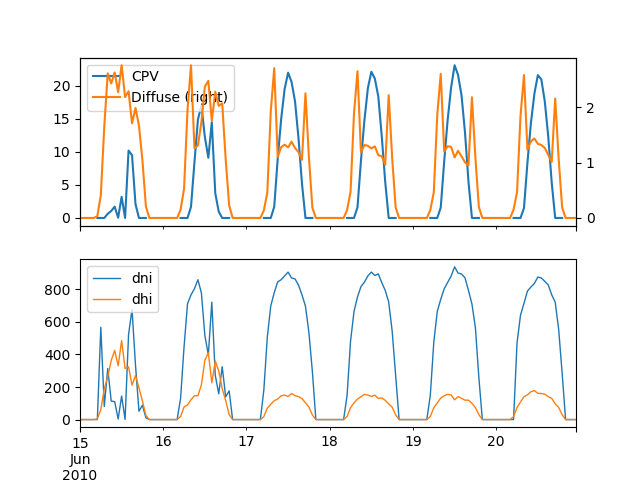

In [16]:
cpv_days = dc_cpv['2010-06-15':'2010-06-20']
uf_cpv_days = uf_cpv['2010-06-15':'2010-06-20']
diffuse_days = dc_diffuse['2010-06-15':'2010-06-20']
data_days = data['2010-06-15':'2010-06-20']

fig, axs = plt.subplots(2)

(cpv_days.p_mp * uf_cpv_days).plot(ax=axs[0], legend=True, label="CPV")
diffuse_days.p_mp.plot(ax=axs[0], secondary_y=True, legend=True, label="Diffuse")
data_days[['dni', 'dhi']].plot(ax=axs[1], linewidth=1)

Energy

In [10]:
energy_cpv = (dc_cpv['p_mp'] * uf_cpv).sum()
energy_diffuse = dc_diffuse['p_mp'].sum()

print(f"E_CPV={energy_cpv:.0f} kWh", f"E_diff={energy_diffuse:.0f} kWh")

E_CPV=28320 kWh E_diff=6107 kWh
